In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
import optuna
%matplotlib inline

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/n

In [2]:
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

# Shuffle dataFrame (don't do this?)
# df = shuffle(df, random_state=101)
# df.head()
df.info()

test_performance_size = 100
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]
print(f'df after perf set removed: {df.shape}')
print(f'df perf set size {test_performance_df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Columns: 218 entries, Unnamed: 0 to D_datediff
dtypes: float64(142), int64(67), object(9)
memory usage: 7.9+ MB
df after perf set removed: (4641, 218)
df perf set size (100, 218)


# Columns to use
(TODO)

In [3]:
df[:5]

,Unnamed: 0,Season,Date,Home_Team,H_Q1,H_Q2,H_Q3,H_Q4,H_OT,H_Final,...,D_punting_lng,D_punting_pnt,D_punting_yds,D_scoring_fga,D_scoring_fgm,D_scoring_xpa,D_scoring_xpm,D_start_odds,D_halftime_odds,D_datediff
0,248,1999,1999-10-17,PIT,7,7,0,3,0,17,...,-4.808,-0.848,-8.640,-0.472,0.648,0.848,0.632,0.0,0.0,0.0
1,245,1999,1999-10-17,CLE,0,7,0,0,0,7,...,-2.192,2.104,105.232,-1.696,-1.952,-1.032,-1.032,0.0,0.0,1.0
2,244,1999,1999-10-17,PHI,7,13,0,0,0,20,...,3.840,3.008,154.488,-0.440,0.200,-0.808,-0.808,0.0,0.0,0.0
3,243,1999,1999-10-17,OAK,10,3,7,0,0,20,...,5.768,-0.824,-26.624,-1.544,-1.848,1.144,1.144,0.0,0.0,0.0
4,227,1999,1999-10-21,KAN,0,7,7,21,0,35,...,10.312,-1.664,-49.992,-0.728,-0.512,1.096,1.096,0.0,0.0,0.0


## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [4]:
cat_cols = []
cont_cols = [
    # Home vs away days since last game
    'H_datediff', 'V_datediff',
    
    # First Downs
    'H_First_Downs', 'V_First_Downs',
    
    # Basic Stats
    'H_Rush', 'V_Rush',
    'H_Yds', 'V_Yds',
    'H_TDs', 'V_TDs',
    'H_Cmp', 'V_Cmp',
    'H_Att', 'V_Att',
    'H_Yd', 'V_Yd',
    'H_TD', 'V_TD',
    'H_INT', 'V_INT',
    'H_Sacked', 'V_Sacked',
    'H_Yards', 'V_Yards',
    'H_Net_Pass_Yards', 'V_Net_Pass_Yards',
    'H_Total_Yards', 'V_Total_Yards',
    'H_Fumbles', 'V_Fumbles',
    'H_Lost', 'V_Lost',
    'H_Turnovers', 'V_Turnovers',
    'H_Penalties', 'V_Penalties',
    #'H_Third_Down_Conv', 'V_Third_Down_Conv',
    #'H_Fourth_Down_Conv', 'V_Fourth_Down_Conv',
    #'H_Time_of_Possession', 'V_Time_of_Possession',
    
    # Passing Detailed
    'H_passing_att', 'V_passing_att',
    'H_passing_cmp', 'V_passing_cmp',
    'H_passing_int', 'V_passing_int',
    'H_passing_lng', 'V_passing_lng',
    'H_passing_sk', 'V_passing_sk',
    'H_passing_td', 'V_passing_td',
    'H_passing_yds', 'V_passing_yds',
    
    # Receiving
    'H_receiving_lng', 'V_receiving_lng',
    'H_receiving_td', 'V_receiving_td',
    'H_receiving_yds', 'V_receiving_yds',
    
    # Rushing Detailed
    'H_rushing_att', 'V_rushing_att',
    'H_rushing_lng', 'V_rushing_lng',
    'H_rushing_td', 'V_rushing_td',
    'H_rushing_yds', 'V_rushing_yds',
    
    # Defense Interceptions
    'H_def_interceptions_int', 'V_def_interceptions_int',
    'H_def_interceptions_lng', 'V_def_interceptions_lng',
    'H_def_interceptions_pd', 'V_def_interceptions_pd',
    'H_def_interceptions_td', 'V_def_interceptions_td',
    'H_def_interceptions_yds', 'V_def_interceptions_yds',
    
    # Defense Fumbles
    'H_fumbles_ff', 'V_fumbles_ff',
    'H_fumbles_fr', 'V_fumbles_fr',
    'H_fumbles_td', 'V_fumbles_td',
    'H_fumbles_yds', 'V_fumbles_yds',
    
    # Defense Tackles
    'H_sk', 'V_sk',
    'H_tackles_ast', 'V_tackles_ast',
    'H_tackles_comb', 'V_tackles_comb',
    'H_tackles_qbhits', 'V_tackles_qbhits',
    'H_tackles_solo', 'V_tackles_solo',
    'H_tackles_tfl', 'V_tackles_tfl',
    
    # Kick Returns
    'H_kick_returns_lng', 'V_kick_returns_lng',
    'H_kick_returns_rt', 'V_kick_returns_rt',
    'H_kick_returns_td', 'V_kick_returns_td',
    'H_kick_returns_yds', 'V_kick_returns_yds',
    
    # Punt Returns
    'H_punt_returns_lng', 'V_punt_returns_lng',
    'H_punt_returns_ret', 'V_punt_returns_ret',
    'H_punt_returns_td', 'V_punt_returns_td',
    'H_punt_returns_yds', 'V_punt_returns_yds',
    
    # Punting/Scoring
    'H_punting_lng', 'V_punting_lng',
    'H_punting_pnt', 'V_punting_pnt',
    'H_punting_yds', 'V_punting_yds',
    'H_scoring_fga', 'V_scoring_fga',
    'H_scoring_fgm', 'V_scoring_fgm',
    'H_scoring_xpa', 'V_scoring_xpa',
    'H_scoring_xpm', 'V_scoring_xpm',
    
    # Odds
    # 'H_start_odds', 'V_start_odds',
    # 'H_halftime_odds', 'V_halftime_odds'
]

cont_cols = [
    'D_datediff', # Days since last game (Home - visitor)
    
    # first downs
    'D_First_Downs',
    
    # Basic Stats
    'D_Rush',
    'D_Yds',
    'D_TDs',
    'D_Cmp',
    'D_Att',
    'D_Yd',
    'D_TD',
    'D_INT',
    'D_Sacked',
    'D_Yards',
    'D_Net_Pass_Yards',
    'D_Total_Yards',
    'D_Fumbles',
    'D_Lost',
    'D_Turnovers',
    'D_Penalties',
    
    # Passing Detailed
    'D_passing_att',
    'D_passing_cmp',
    'D_passing_int',
    'D_passing_lng',
    'D_passing_sk',
    'D_passing_td',
    'D_passing_yds',
    
    # Receiving
    'D_receiving_lng',
    'D_receiving_td',
    'D_receiving_yds',
    
    # Rushing Detailed
    'D_rushing_att',
    'D_rushing_lng',
    'D_rushing_td',
    'D_rushing_yds',
    
    # Defense interceptions
    'D_def_interceptions_int',
    'D_def_interceptions_lng',
    'D_def_interceptions_pd',
    'D_def_interceptions_td',
    'D_def_interceptions_yds',
    
    # Defense fumbles
    'D_fumbles_ff',
    'D_fumbles_fr',
    'D_fumbles_td',
    'D_fumbles_yds',
    
    # Defense tackles
    'D_sk',
    'D_tackles_ast',
    'D_tackles_comb',
    'D_tackles_qbhits',
    'D_tackles_solo',
    'D_tackles_tfl',
    
    # Kick Returns
    'D_kick_returns_lng',
    'D_kick_returns_rt',
    'D_kick_returns_td',
    'D_kick_returns_yds',
    
    # Punt Returns
    'D_punt_returns_lng',
    'D_punt_returns_ret',
    'D_punt_returns_td',
    'D_punt_returns_yds',
    
    # Punting / Scoring
    'D_punting_lng',
    'D_punting_pnt',
    'D_punting_yds',
    'D_scoring_fga',
    'D_scoring_fgm',
    'D_scoring_xpa',
    'D_scoring_xpm'
]


y_col = ['H_Won']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']

# create cont_df and y_df from the df
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]

print(cont_df.dtypes)

D_datediff       float64
D_First_Downs      int64
D_Rush             int64
D_Yds              int64
D_TDs              int64
                  ...   
D_punting_yds    float64
D_scoring_fga    float64
D_scoring_fgm    float64
D_scoring_xpa    float64
D_scoring_xpm    float64
Length: 62, dtype: object


#### 1a. Normalize cont_df

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
cont_scaled = min_max_scaler.fit_transform(cont_df.values)
cont_df = pd.DataFrame(cont_scaled)
cont_df.head()

# test performance set
perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [6]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)

### 4. Convert conts to tensor

In [7]:
print(conts.shape)
print(y_col.shape)

(4641, 62)
(4641, 1)


In [8]:
conts = torch.tensor(conts, dtype=torch.float32)
y_col = torch.tensor(y_col, dtype=torch.float32)

In [9]:
print(conts.shape)
print(y_col.shape)

torch.Size([4641, 62])
torch.Size([4641, 1])


### 5. Create train, test, and holdout sets from cats, conts, and y
cats currently is unused

In [10]:
holdout_size = 300

# Train & test set minus holdout
holdout_limit = len(conts) - holdout_size

conts_train_test = conts[:holdout_limit]
y_col_train_test = y_col[:holdout_limit]

train_size = int(0.85 * len(conts_train_test))
test_size = len(conts_train_test) - train_size

conts_train = conts_train_test[:train_size]
conts_test = conts_train_test[train_size:]

y_train = y_col_train_test[:train_size]
y_test = y_col_train_test[train_size:]

# Holdout set
holdout_conts = conts[holdout_limit:]
holdout_y = y_col[holdout_limit:]

In [11]:
class TabularModel(nn.Module):
    def __init__(self, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        # No embedding since there's no categorical data
        # set up batch norm layer attributes
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        
        # no embed again
        n_in = n_cont
        
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(layers):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.ReLU(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(layers[-1], out_sz),
            nn.Sigmoid()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cont):
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        
        # Set up model layers
        x = self.layers(x_cont)
        return x

### Hyperparameter search using optuna

In [12]:
# Number of epochs
n_train_iter = 1000

def objective(trial):
    # --- Suggest hyperparameters ---
    layers = trial.suggest_categorical(
        'layers', 
        [
            [32, 16],       # 2 layers
            [32, 16, 8],    # 3 layers
            [32, 16, 8, 4], # 4 layers
            [16, 8],        # 2 layers
            [16, 8, 4],     # 3 layers
            [8, 4],         # 2 layers
            [64, 32, 16, 8],# 4 layers
            [64, 32, 16],   # 3 layers
            [48, 24, 12, 6],# 4 layers
            [48, 24]        # 2 layers
        ]
    )
    p = trial.suggest_float('dropout', 0.2, 0.5)           # Dropout
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)   # Learning rate 
    batch_size = trial.suggest_int('batch_size', 900, 10000, log=True) # Batch size

    
    # Create dataset
    dataset = TensorDataset(conts_train, y_train)

    # Create dataloader
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    # out_sz and n_cont stay unchanged
    model = TabularModel(conts.shape[1], 1, layers, p)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    for epoch in range(n_train_iter):
        model.train()
        running_loss = 0.0

        # Run the training over batches
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model.forward(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        trial.report(running_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

            
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        # Apply the model
        y_val = model.forward(conts_test)
        test_loss = criterion(y_val, y_test)
        test_loss_result = test_loss.item()
    return test_loss_result
            
def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [13]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=n_train_iter
    )
)
# Uncomment to run
if False:
    study.optimize(objective, n_trials=3, callbacks=[print_callback])

    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

[I 2024-12-01 22:13:11,380] A new study created in memory with name: no-name-b6b2cead-6c86-4da2-899d-471c95f3b810


# Using XGBoost

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

In [15]:
conts_train.shape

torch.Size([3689, 62])

In [16]:
# Fit the model
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}


model = XGBClassifier(eval_metric='logloss')

## Tune hyperparameters
#grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
#grid_search.fit(conts_train, y_train)


In [17]:
print(grid_search.best_params_)
# 60.15%, {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

NameError: name 'grid_search' is not defined

In [18]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_
    **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train), (holdout_conts, holdout_y)],
    verbose=True
)

[0]	validation_0-logloss:0.69160	validation_1-logloss:0.69243
[1]	validation_0-logloss:0.68990	validation_1-logloss:0.69152
[2]	validation_0-logloss:0.68825	validation_1-logloss:0.69039
[3]	validation_0-logloss:0.68652	validation_1-logloss:0.68957
[4]	validation_0-logloss:0.68477	validation_1-logloss:0.68855
[5]	validation_0-logloss:0.68337	validation_1-logloss:0.68784
[6]	validation_0-logloss:0.68177	validation_1-logloss:0.68703
[7]	validation_0-logloss:0.68025	validation_1-logloss:0.68621
[8]	validation_0-logloss:0.67854	validation_1-logloss:0.68528
[9]	validation_0-logloss:0.67698	validation_1-logloss:0.68463
[10]	validation_0-logloss:0.67546	validation_1-logloss:0.68387
[11]	validation_0-logloss:0.67388	validation_1-logloss:0.68317
[12]	validation_0-logloss:0.67238	validation_1-logloss:0.68271
[13]	validation_0-logloss:0.67088	validation_1-logloss:0.68201
[14]	validation_0-logloss:0.66935	validation_1-logloss:0.68141
[15]	validation_0-logloss:0.66791	validation_1-logloss:0.68052
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [19]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(conts_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.51%


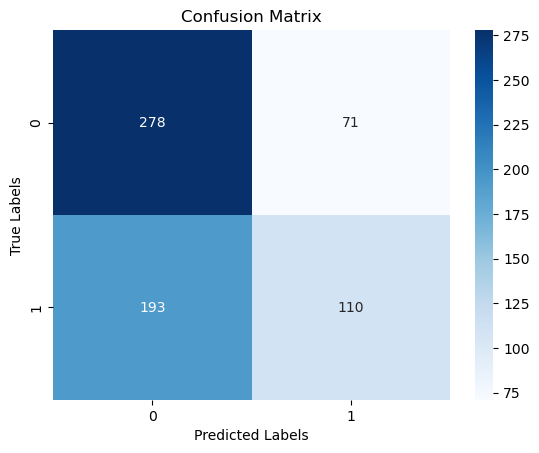

In [20]:
# Make confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Test against performance data (includes odds)


In [23]:
perf_conts = torch.tensor(perf_conts, dtype=torch.float32)
perf_y_col = torch.tensor(perf_y_col, dtype=torch.float32)

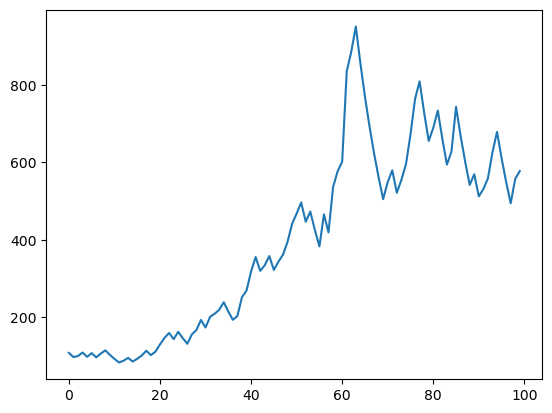

In [36]:
perf_y_pred = model.predict(perf_conts)
predictions = [1 if value >= 0.55 else 0 for value in perf_y_pred]

# Assumes the following
# Column 0: H_Won
#        1: H_start_odds
#        2: V_start_odds

account_value = 100
position_size = 0.1
x_axis = []
y_axis = []
for i in range(0,len(predictions)):
    amt_won = -(position_size * account_value)
    # correct prediction
    if perf_y_col[i][0] == predictions[i]:
        won_odds = perf_y_col[i][1] if perf_y_col[i][0] == 1 else perf_y_col[i][2]
        amt_won = abs(amt_won) * (won_odds - 1)
    # Update account value
    # print(amt_won)
    account_value = account_value + amt_won
    x_axis.append(i)
    y_axis.append(account_value)
plt.plot(x_axis, y_axis)
plt.show()

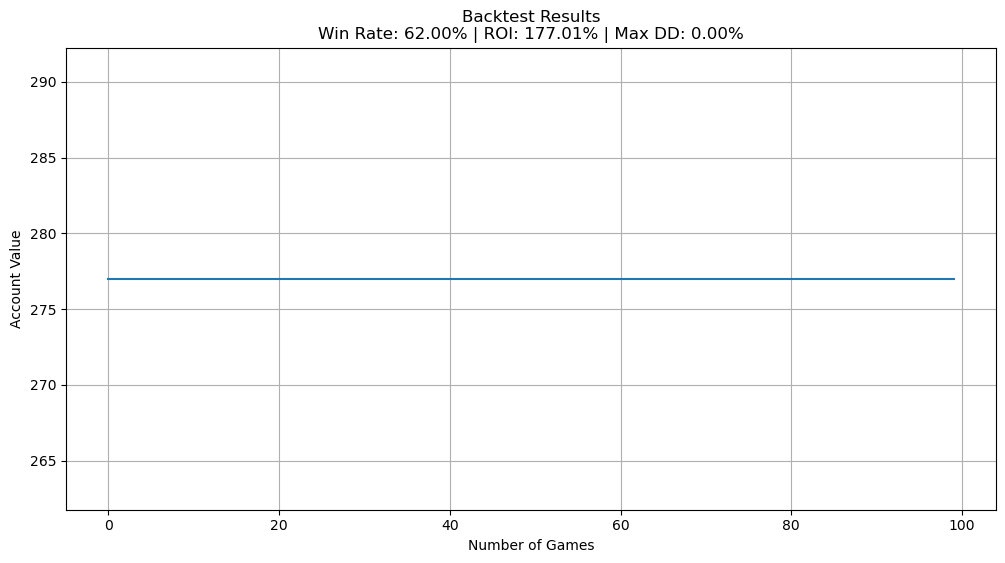

{'final_value': tensor(277.0055),
 'roi': tensor(1.7701),
 'win_rate': 0.62,
 'max_drawdown': 0,
 'total_bets': 100}

In [37]:
def backtest_model(model, perf_conts, perf_y_col, initial_capital=100, position_size=0.05, 
                   prob_threshold=0.55):
    account_value = initial_capital
    x_axis = []
    y_axis = []
    wins = 0
    total_bets = 0
    max_value = initial_capital
    max_drawdown = 0
    
    # Get probabilities instead of rounded predictions
    prob_predictions = model.predict(perf_conts)
    
    for i in range(len(prob_predictions)):
        # Only bet if confidence exceeds threshold
        if prob_predictions[i] >= prob_threshold or prob_predictions[i] <= (1 - prob_threshold):
            total_bets += 1
            
            # Calculate position size (could be dynamic based on confidence)
            bet_size = account_value * position_size
            
            # Determine prediction and actual outcome
            prediction = 1 if prob_predictions[i] >= prob_threshold else 0
            actual = perf_y_col[i][0]
            
            # Calculate profit/loss
            if actual == prediction:
                wins += 1
                won_odds = perf_y_col[i][1] if actual == 1 else perf_y_col[i][2]
                amt_won = bet_size * (won_odds - 1)
            else:
                amt_won = -bet_size
            
            # Update account value and track metrics
            account_value += amt_won
            max_value = max(max_value, account_value)
            current_drawdown = (max_value - account_value) / max_value
            max_drawdown = max(max_drawdown, current_drawdown)
            
        x_axis.append(i)
        y_axis.append(account_value)
    
    # Calculate performance metrics
    win_rate = wins / total_bets if total_bets > 0 else 0
    roi = (account_value - initial_capital) / initial_capital
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, y_axis)
    plt.title(f'Backtest Results\nWin Rate: {win_rate:.2%} | ROI: {roi:.2%} | Max DD: {max_drawdown:.2%}')
    plt.xlabel('Number of Games')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.show()
    
    return {
        'final_value': account_value,
        'roi': roi,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'total_bets': total_bets
    }

backtest_model(model, perf_conts, perf_y_col, initial_capital=100, position_size=0.05, 
                   prob_threshold=0.55)

monotone_constraints = {
    # Time between games - More rest is better
    'D_datediff': 1,
    
    # Offensive positive indicators
    'D_First_Downs': 1,
    'D_Rush': 1,
    'D_Yds': 1,
    'D_TDs': 1,
    'D_Cmp': 1,
    'D_Yd': 1,
    'D_TD': 1,
    'D_Net_Pass_Yards': 1,
    'D_Total_Yards': 1,
    
    # Negative indicators
    'D_INT': -1,
    'D_Sacked': -1,
    'D_Fumbles': -1,
    'D_Lost': -1,
    'D_Turnovers': -1,
    'D_Penalties': -1,
    
    # Passing detail - positive
    'D_passing_cmp': 1,
    'D_passing_td': 1,
    'D_passing_yds': 1,
    'D_passing_lng': 1,
    
    # Passing detail - negative
    'D_passing_int': -1,
    'D_passing_sk': -1,
    
    # Receiving/Rushing - all positive
    'D_receiving_td': 1,
    'D_receiving_yds': 1,
    'D_receiving_lng': 1,
    'D_rushing_td': 1,
    'D_rushing_yds': 1,
    'D_rushing_lng': 1,
    
    # Defense - generally positive when in your favor
    'D_def_interceptions_int': 1,
    'D_def_interceptions_td': 1,
    'D_def_interceptions_yds': 1,
    'D_fumbles_fr': 1,
    'D_fumbles_td': 1,
    'D_sk': 1,
    'D_tackles_qbhits': 1,
    'D_tackles_tfl': 1,
    
    # Special teams - positive indicators
    'D_kick_returns_td': 1,
    'D_kick_returns_yds': 1,
    'D_punt_returns_td': 1,
    'D_punt_returns_yds': 1,
    
    # Scoring - positive
    'D_scoring_fgm': 1,
    'D_scoring_xpm': 1
}